# Quantile Regression, Envelope Fitting, and Daily PV Energy

Convex optimization provides a great framework for generalized data fitting and model building. In this post, we'll explore the concept of "quantile regression" which allows us to approximately fit a certain quantile of a residual distribution. This is particularly useful when your residuals are not normally distributed. Along the way, we'll also talk about convex optimization as a framework for generalized model fitting and smoothing.

To motivate this discussion, we'll work with the daily energy signal from a photovoltaic device. We'll be looking at [global horizontal irradiance](https://pvpmc.sandia.gov/modeling-steps/1-weather-design-inputs/irradiance-and-insolation-2/global-horizontal-irradiance/) data as measured by a [pyranometer](https://en.wikipedia.org/wiki/Pyranometer).

This post is laid out as follows:

1. The data
2. Background on statistical smoothing
3. Robust estimation
4. Quantile regression
5. Conclusion / what next?


## The data

As always, we begin with some standard imports.

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cvx
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='talk', palette='colorblind', style='darkgrid')

We're grabbing data from NREL's [National Solar Radiation Data Base](http://rredc.nrel.gov/solar/old_data/nsrdb/). We have arbitrarily selected the 2010 data set for `USAF #723013 - WILMINGTON INTERNATIONAL ARPT, NC`. Here we show off how easy `pandas` makes it to load `csv` files hosted on the internet.

In [76]:
link = 'http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2010/data/hourly/723013/723013_2010_solar.csv'
df = pd.read_csv(link, index_col=[0,1])
print df.head()

                        Zenith (deg)  Azimuth (deg)  ETR (Wh/m^2)  \
YYYY-MM-DD HH:MM (LST)                                              
2010-01-01 1:00                 99.0          -99.0             0   
           2:00                 99.0          -99.0             0   
           3:00                 99.0          -99.0             0   
           4:00                 99.0          -99.0             0   
           5:00                 99.0          -99.0             0   

                        ETRN (Wh/m^2)  SUNY Glo (Wh/m^2)  SUNY Glo Flg  \
YYYY-MM-DD HH:MM (LST)                                                   
2010-01-01 1:00                     0              -9900            99   
           2:00                     0              -9900            99   
           3:00                     0              -9900            99   
           4:00                     0              -9900            99   
           5:00                     0              -9900            99  

Next, we isolate the global horizonal irradiance (GHI) column from this data table.

In [3]:
ghi = df['METSTAT Glo (Wh/m^2)'].as_matrix()

It's always a good idea to plot your data before working with it, so let's take a quick look. Below we see the first five days of the data set. The first day is pretty cloudy and the next four are clearer.

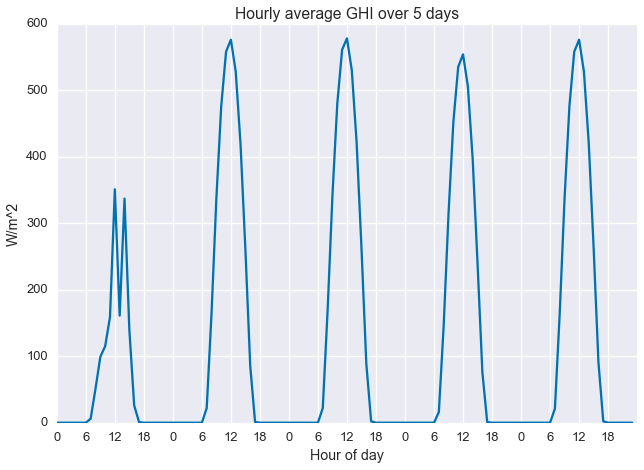

In [4]:
plt.plot(ghi[:24*5])
plt.xlabel('Hour of day')
plt.xticks(np.arange(0, 24*5, 6), np.tile(np.arange(0, 24, 6), 5))
plt.ylabel('W/m^2')
plt.title('Hourly average GHI over 5 days')
plt.show()

I really like "heatmap" views for solar data sets. It allows us to easily view all the data at once, and it emphasizes the seasonal structure of the data.

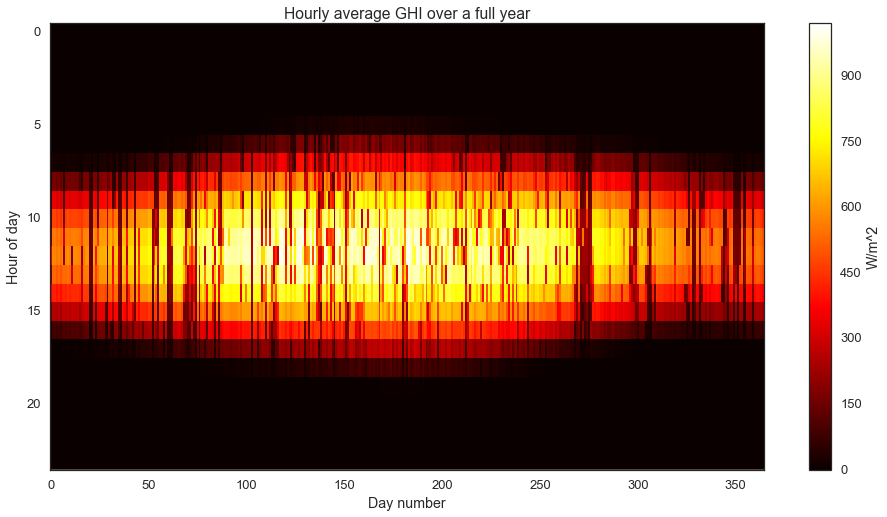

In [5]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(ghi.reshape((24,-1), order='F'), cmap='hot', aspect='auto', interpolation='none')
    plt.colorbar(label='W/m^2')
    plt.title('Hourly average GHI over a full year')
    plt.ylabel('Hour of day')
    plt.xlabel('Day number')

We can clearly see the longer, sunnier days in the summer and the shorter, less energetic days in the winter. On top of this longer seasonal pattern, we observe the impact of weather and clouds as the darker "noise".

Getting to the point, we run a simple statistic on the data: the daily sum. This gives us total _total daily insolation_, which is energy per unit area. The sunnier a day, the higher its insolation.

In [6]:
daily_insol = np.sum(ghi.reshape(-1, 24), axis=1) / 1000.

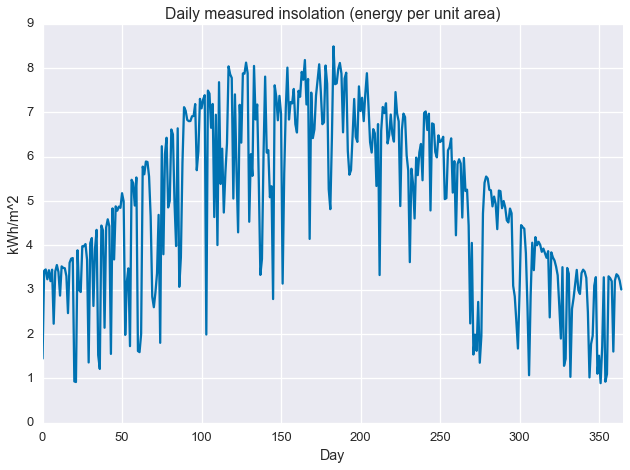

In [7]:
plt.plot(daily_insol)
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.title('Daily measured insolation (energy per unit area)')
plt.xlim(0, 365)
plt.show()

As with the image/heatmap view of the hourly irradiance data, we see a clear seasonal structure with deviations caused by intermittant weather phenomenon. There appears to be sharp maximum cutoff that changes slowly over the course of the year, with deviations from this cutoff always in the negative direction. This sharp maximum is related the concept of "clear sky performance," or how much power a PV system (or irradiance sensor) produces when the sky is clear. For that reason, we may be interested in describing this maximum cutoff. This is what we'll use quantile regression to find.

## Background: statistical smoothing

There are a large number tools available to the analyst who wishes to perform a smoothing fit of a dataset. You've got your [smoothing splines](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.UnivariateSpline.html), [kernal smoothing](https://en.wikipedia.org/wiki/Kernel_smoother), and [local regression](https://en.wikipedia.org/wiki/Local_regression). All these techniques take observed samples $(x_i,y_i)$ for $i=1,\ldots,n$, and attempt to fit a smooth function $\hat{y}=\hat{f}(x)$ to the given data. Unlike traditional regression or function fitting, very little is assumed about the underlying model. The amount of "smoothing" induced by these techniques is controlled by selecting the size of the "neighborhood", the larger the neighborhood, the more data used in every point estimate of the smooth function, the smoother the result. They all make the assumption that was we observe is some smooth function corrupted by Gaussian noise and more or less provide an estimate of the local average of the data.

A nearly identical result can be derived via convex optimization. In this context, we encode our observations as elements of a vector $y\in\mathbf{R}^n$. Then, we try to find an approximation $\hat{y}\in\mathbf{R}^n$ that close to $y$ in terms of root-mean-square error while also being smooth. We estimate smoothness as the discrete approximation of the first or second derivative of the signal, given by the [finite difference operator](https://en.wikipedia.org/wiki/Finite_difference) $\mathcal{D}$, where first-order difference is an approximation of the first derivative and the second-order difference is an approximation of the second derivative. This gives us the following convex optimization problem

$$
\begin{alignat*}{2}
& \underset{\hat{y}\in\mathbf{R}^n}{\text{minimize}}
& & \quad \left\lVert y - \hat{y} \right\rVert_2 + \mu \left\lVert \mathcal{D} \hat{y} \right\rVert_2
\end{alignat*}
$$

When $\mu$ is equal to zero, the solution to the above problem is exactly $\hat{y}=y$, but a non-zero $\mu$ gives us the kind of standard smoothing we'd expect from the classic methods mentioned above. We call this a _non-parametric model_ because our model $(\hat{y})$ has exactly as many free parameters as the data itself $(y)$. Because we're minimizing the $\ell_2$-norm of the difference operator, we call this quadradic smoothing (as opposed to, say, minimizing [total variation](https://en.wikipedia.org/wiki/Total_variation), based on the $\ell_1$-norm.) Below we see how first- and second-order difference smoothing works with our daily insolation data, at various values of $\mu$.

> ##### Side note: Why do we care about formulating things as convex optimization problems?
>
> Two reasons. One, convexity guarantees that the problem has a single, global minimum and no other local minima. Two, convex optimization problems are easy to solve. We have efficient algorithms for solving these problems and methods to scale them up to very large data sets. As a counter example, stochastic gradient descent (SGD) can minimize just about any function (including non-convex ones), but it's pretty slow. In general, there tends to be a tradeoff between robustness and speed. Algorithms that are guaranteed to work on every problem, like SDG, tend not to be very fast because they are not exploiting any structure in the problem. Non-robust algorithms only work on problems with a specific type of structure, but are extremely efficient. A classic example is least-squares regression, which is a convex optimization problem with a closed form solution, no SGD needed.

#### First-order difference, quadratic smoothing

The first order difference of vector $x\in\mathbf{R}^n$ is a linear transform given by the matrix

$$
\mathcal{D}_1 = \left[\begin{matrix} -1 & 1 & 0 & \cdots & 0 & 0 & 0 \\
0& -1 & 1 & \cdots & 0 & 0 & 0 \\
0 & 0 & -1 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots &\ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -1 & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & -1 & 1\end{matrix}\right] \in \mathbf{R}^{(n-1)\times n}
$$

If $y=\mathcal{D}_1 x$, then $y_i = x_{i+1}-x_i$. So, as long as the measurements are evenly spaced, this transform gives the slope between each pair of measurements. Driving this metric to zero results in an estimate with no slope, i.e. a constant value.

Here we use `cvxpy` to set up the optimization problem for this smoothing.

In [8]:
fit = cvx.Variable(len(daily_insol))
mu = cvx.Parameter(sign='positive', value=1e3)
objective = cvx.Minimize(cvx.norm(daily_insol - fit, 2) + mu * cvx.norm(cvx.diff(fit, 1), 2))
problem = cvx.Problem(objective)

Next we iterate over values of $\mu$ and plot the results.

In [9]:
fits = []
mus = np.logspace(-0.5, 1.7, 7)
for m in mus:
    mu.value = m
    problem.solve(solver='MOSEK')
    fits.append(fit.value.A1)

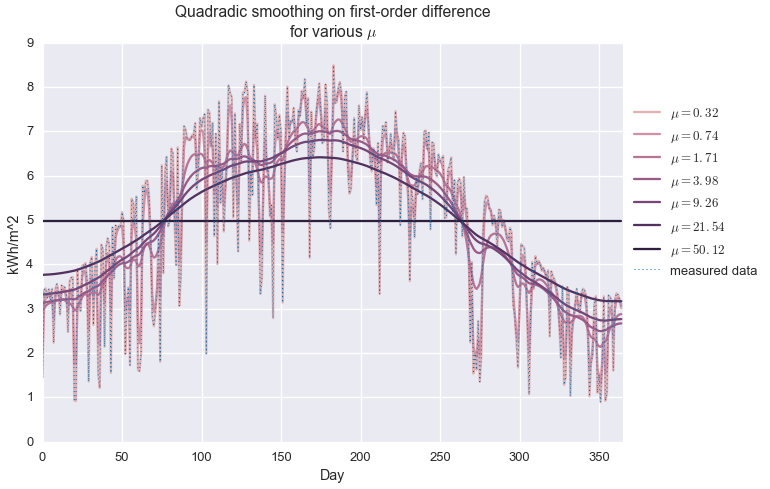

In [10]:
colors = sns.cubehelix_palette(len(mus), light=0.75)
for i in xrange(len(mus)):
    plt.plot(fits[i], color=colors[i], label='$\\mu={:.2f}$'.format(mus[i]))
plt.plot(daily_insol, linewidth=1, ls=':', label='measured data')
plt.legend(loc=[1.01, 0.4])
plt.title('Quadradic smoothing on first-order difference\nfor various $\\mu$')
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.xlim(0, 365)
plt.show()

We see that when $\mu$ is very small, the observed data is exactly reconstructed and no smoothing is performed. For very large $\mu$, the estimate is a perfectly flat line, at the average of the data set. In between, we observe varying levels of smoothing. At about $\mu=20$, we get an approximation that kind of looks like a seasonal trend, but it's not great. It definitely is not capturing the shape of the upper envelope of the signal.

#### Second-order difference, quadratic smoothing

We approximate the local second derivative of the signal through the second order difference of vector $x\in\mathbf{R}^n$, which is a linear transform given by the matrix

$$
\mathcal{D}_2 = \left[\begin{matrix} 
1 & -2 & 1 & \cdots & 0 & 0 & 0 & 0 \\
0& 1 & -2 & \cdots & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & \cdots & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots &\ddots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & 1 & -2 & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1 & -2 & 1\end{matrix}\right] \in \mathbf{R}^{(n-2)\times n}
$$

If $y=\mathcal{D}_2 x$, then $y_i = x_{i}-2x_{i+1} + x_{i+2}$. So, as long as the measurements are evenly spaced, this transform gives the discrete estimate of the local curvature. Driving this metric to zero results in an estimate with constant slope, i.e. an affine function.

In [11]:
fit = cvx.Variable(len(daily_insol))
mu = cvx.Parameter(sign='positive', value=1e3)
objective = cvx.Minimize(cvx.norm(daily_insol - fit, 2) + mu * cvx.norm(cvx.diff(fit, 2), 2))
problem = cvx.Problem(objective)

In [12]:
fits = []
mus = np.logspace(-1, 3.7, 7)
for m in mus:
    mu.value = m
    problem.solve(solver='MOSEK')
    fits.append(fit.value.A1)

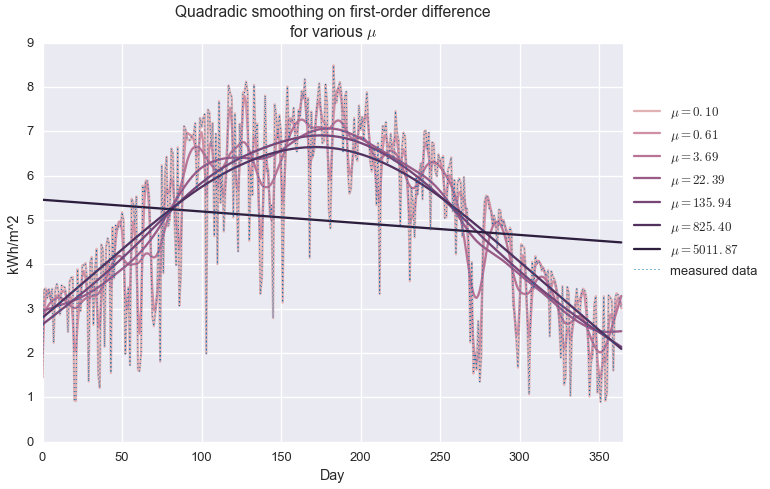

In [13]:
colors = sns.cubehelix_palette(len(mus), light=0.75)
for i in xrange(len(mus)):
    plt.plot(fits[i], color=colors[i], label='$\\mu={:.2f}$'.format(mus[i]))
plt.plot(daily_insol, linewidth=1, ls=':', label='measured data')
plt.legend(loc=[1.01, 0.4])
plt.title('Quadradic smoothing on first-order difference\nfor various $\\mu$')
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.xlim(0, 365)
plt.show()

Here's the behavior of quadratic smoothing on the second-order difference. As with the last example, when $\mu$ is very small, the estimate exactly matches in the imput data. As expected, we get an affine function rather than a constant function at large $\mu$.

Interestingly, the range of $\mu$ is much wider in this example than the last one. This is actually desirable behavior. We are not usually interested in the behavior at the extremes ($\mu$ very small or vary large), but in the the middle, where rapid fluctuations are smoothed out but the large scale behavior isn't lost. Quadratic smoothing on the second-order difference has a much larger _stable region_ of values of $\mu$ as compared to the first-order difference.

Below, we compare the best solutions for both methods.

In [14]:
fit = cvx.Variable(len(daily_insol))
mu = cvx.Parameter(sign='positive', value=20)
objective = cvx.Minimize(cvx.norm(daily_insol - fit, 2) + mu * cvx.norm(cvx.diff(fit, 1), 2))
problem = cvx.Problem(objective)
problem.solve(solver='MOSEK')
fits = [fit.value.A1]
mu = cvx.Parameter(sign='positive', value=1e2)
objective = cvx.Minimize(cvx.norm(daily_insol - fit, 2) + mu * cvx.norm(cvx.diff(fit, 2), 2))
problem = cvx.Problem(objective)
problem.solve(solver='MOSEK')
fits.append(fit.value.A1)

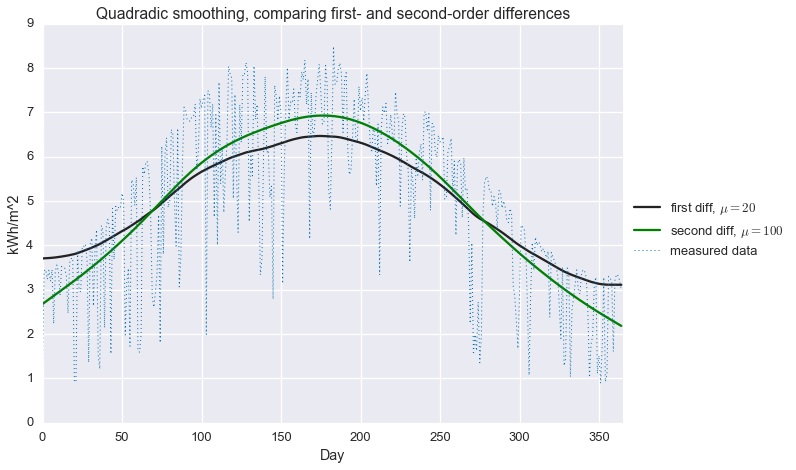

In [15]:
colors = sns.dark_palette('green', 2)
plt.plot(fits[0], color=colors[0], label='first diff, $\\mu=20$')
plt.plot(fits[1], color=colors[1], label='second diff, $\\mu=100$')
plt.plot(daily_insol, linewidth=1, ls=':', label='measured data')
plt.legend(loc=[1.01, 0.4])
plt.title('Quadradic smoothing, comparing first- and second-order differences')
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.xlim(0, 365)
plt.show()

While the second-order difference appears to be a bit better (smoother without attenuating the seasonal fluctuation), neither of these approaches does a very good job explaining our GHI data. In particular, we most certainly do not have a good estimate of that hard maximum cutoff that that is associated to clear sky performance. This brings us to...

## Robust estimation

Robust statistical estimation is primarly concerned with developing techniques that do not rely on the assumption that errors are normally distributed. A common approach to this problem is to replace the $\ell_2$-loss (RMSE) used in our previous formulation with the $\ell_1$-loss.

$$
\begin{alignat*}{2}
& \text{minimize}
& & \quad \left\lVert y - \hat{y} \right\rVert_1 + \mu \left\lVert \mathcal{D} \hat{y} \right\rVert_2
\end{alignat*}
$$

All norms, including the $\ell_1$-norm, are convex functions, so this is still a convex optimization problem. This loss function is linear with increasing residual values. Unlike the $\ell_2$-loss, the $\ell_1$-loss does not "blow up" in the presence of large residuals, making it more resilliant to outliers in the data. Roughly speaking, we can think of this function as fitting the local median of the data, rather than the local average.

Below, we compare the $\ell_1$-loss to the $\ell_2$-loss. Both forulations use quadratic smoothing on the second-order difference.

In [16]:
fit = cvx.Variable(len(daily_insol))
mu = cvx.Parameter(sign='positive', value=1.3e3)
objective = cvx.Minimize(cvx.norm(daily_insol - fit, 1) + mu * cvx.norm(cvx.diff(fit, 2), 2))
problem = cvx.Problem(objective)
problem.solve(solver='MOSEK')
fits = [fit.value.A1]
mu = cvx.Parameter(sign='positive', value=1e2)
objective = cvx.Minimize(cvx.norm(daily_insol - fit, 2) + mu * cvx.norm(cvx.diff(fit, 2), 2))
problem = cvx.Problem(objective)
problem.solve(solver='MOSEK')
fits.append(fit.value.A1)
fit_quadratic = fits[1]

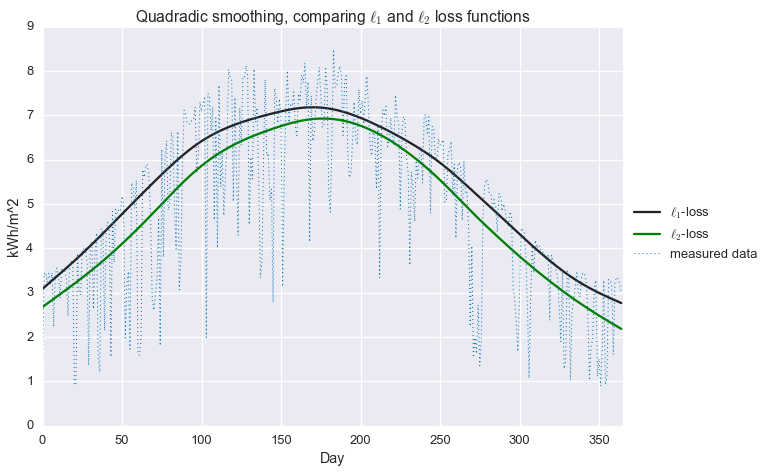

In [17]:
colors = sns.dark_palette('green', 2)
plt.plot(fits[0], color=colors[0], label='$\\ell_1$-loss')
plt.plot(fits[1], color=colors[1], label='$\ell_2$-loss')
plt.plot(daily_insol, linewidth=1, ls=':', label='measured data')
plt.legend(loc=[1.01, 0.4])
plt.title('Quadradic smoothing, comparing $\\ell_1$ and $\ell_2$ loss functions')
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.xlim(0, 365)
plt.show()

That's an improvement! At least in the winter, we're now much closer to estimating that top envelope of the signal. But we can do better still, with...

## Quantile regression

Now we get to the heart of the matter. We introduce a new penalty function, which is a tilted version of the $\ell_1$ loss function. What does that mean? Well, for a given residual $r=y-\hat{y}$, we can write the familiar $\ell_2$-loss as

$$ \phi_{\ell_2}(r) = r^2 $$

and the $\ell_1$-loss as

$$ \phi_{\ell_1}(r) = \left\lvert r \right\rvert $$

The _quantile regression loss function_ or _tilted $\ell_1$ penalty_ is defined as

$$\phi_{\tau}(r) = \tau (x)_+ + (1-\tau)(x)_- = \frac{1}{2}\left\lvert x \right\rvert + \left(\tau -\frac{1}{2}\right)x$$

where $\tau\in(0,1)$ and

$$(x)_+ = \max\left\{0, x\right\},\quad\quad (x)_- = \max\left\{0, -x\right\}$$

This is still a convex function, so we can happily use it in place of our standard square error loss. Note that when $\tau=\frac{1}{2}$, this loss is the same as the $\ell_1$-penalty (with a scale factor). Below are plots of these three functions, using $\tau=0.9$ for the tilted $\ell_1$-loss. 

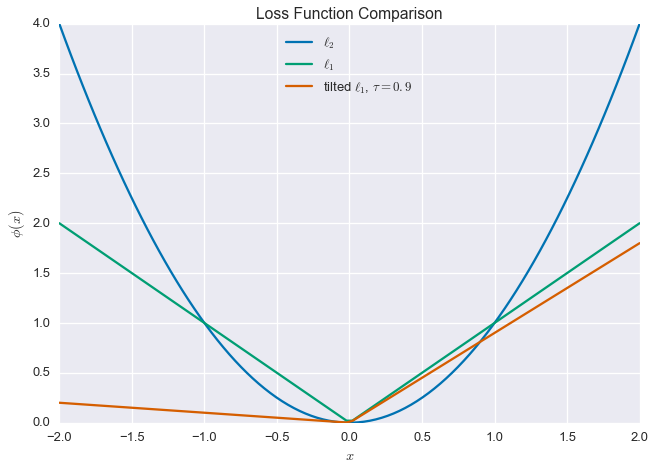

In [18]:
tau = 0.9
x = np.linspace(-2, 2, 100)
plt.plot(x, x**2, label='$\\ell_2$')
plt.plot(x, np.abs(x), label='$\\ell_1$')
plt.plot(x, 0.5 * np.abs(x) + (tau - 0.5) * x, label='tilted $\\ell_1$, $\\tau=0.9$')
plt.xlabel('$x$')
plt.ylabel('$\\phi(x)$')
plt.legend(loc=9)
plt.title('Loss Function Comparison')
plt.show()

Why use this loss function? Intuitively, the fact that the loss is not symmetric means that we allow larger residuals one side of this fit. When $\tau > \frac{1}{2}$, we allow larger negative residuals, and when $\tau < \frac{1}{2}$, we allow larger positive residuals. In fact, if there are $n$ data points, this method gives you approximately $n\tau$ residuals below the fit, and $(1-n)\tau$ residuals above the fit, which is why this approach is called _quantile regression_.

Alright, let's see it in action. Below, we perform non-parametric quantile regression with quadradic smoothing on the second-order difference (phew, that's a mouthful). In mathematical terms, we're solving the following problem:

$$
\begin{alignat*}{2}
& \underset{\hat{y}\in\mathbf{R}^n}{\text{minimize}}
& & \quad \sum_{i=1}^n \phi_{\tau}(y_i-\hat{y}_i) + \mu \left\lVert \mathcal{D}_2 \hat{y} \right\rVert_2
\end{alignat*}
$$

We'll iterate over values of $\tau$ and compare the results to the more common $\ell_2$ and $\ell_1$ losses.

In [73]:
fit = cvx.Variable(len(daily_insol))
tau = cvx.Parameter(sign='positive', value=0.5)
mu = cvx.Parameter(sign='positive', value=1e3)
f1 = cvx.sum_entries(0.5 * cvx.abs(daily_insol - fit) + (tau - 0.5) * (daily_insol - fit))
f2 = mu * cvx.norm(cvx.diff(fit, 2), 2)
objective = cvx.Minimize(f1 + f2)
problem = cvx.Problem(objective)

In [74]:
fits = []
taus = np.linspace(0.0, 1, 11)
taus = np.r_[0.01, taus[1:-1], 0.99]
for t in taus:
    tau.value = t
    mu.value = 1e4 * min(t, 1-t)
    problem.solve(solver='MOSEK')
    fits.append(fit.value.A1)

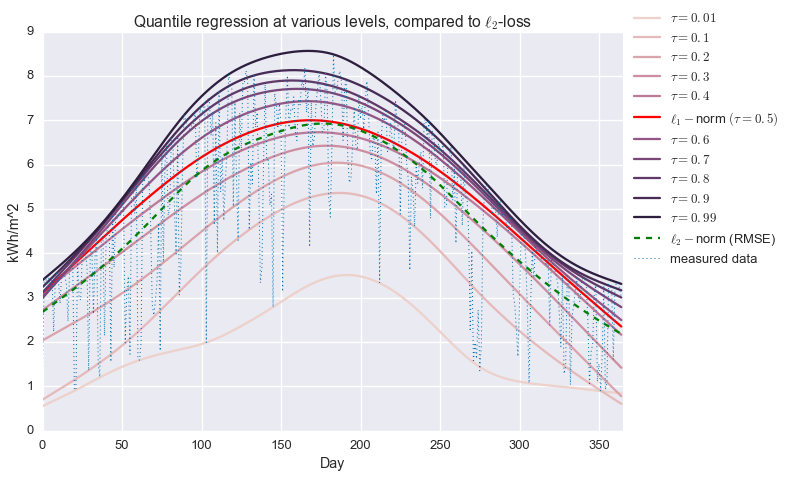

In [75]:
colors = sns.cubehelix_palette(len(taus))
for i in xrange(len(taus)):
    if taus[i] != 0.5:
        plt.plot(fits[i], color=colors[i], label='$\\tau={}$'.format(taus[i]))
    else:
        plt.plot(fits[i], color='red', label='$\\ell_1-$norm $(\\tau={})$'.format(taus[i]))
plt.plot(fit_quadratic, color='green', label='$\\ell_2-$norm (RMSE)', ls='--')
plt.plot(daily_insol, linewidth=1, ls=':', label='measured data')
plt.legend(loc=[1.01, 0.4])
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.xlim(0, 365)
plt.title('Quantile regression at various levels, compared to $\\ell_2$-loss')
plt.show()

Alright! We are now fitting localized quantiles of the data. As $\tau$ gets larger, our fit shifts towards the top of the data. With this method in our toolkit, we're ready to get that clear sky signal. We'll fit the quantile regression model with $\tau=0.95$ and $\mu=200$, which were picked manually to give the best fit.

In [65]:
fit = cvx.Variable(len(daily_insol))
tau = cvx.Parameter(sign='positive', value=0.95)
mu = cvx.Parameter(sign='positive', value=2e2)
objective = cvx.Minimize(cvx.sum_entries(0.5 * cvx.abs(daily_insol - fit) +
                                         (tau - 0.5) * (daily_insol - fit)) +
                         mu * cvx.norm(cvx.diff(fit, 2), 2))
problem = cvx.Problem(objective)
problem.solve(solver='MOSEK')

23.262849044756763

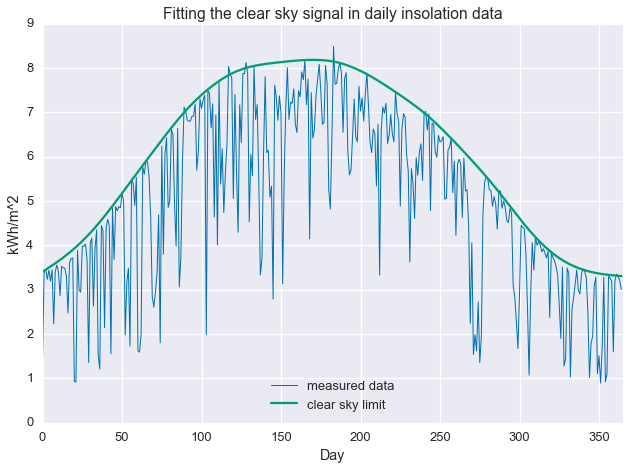

In [66]:
plt.plot(daily_insol, linewidth=1, label='measured data')
plt.plot(fit.value.A1, label='clear sky limit')
plt.ylabel('kWh')
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.xlim(0, 365)
plt.title('Fitting the clear sky signal in daily insolation data')
plt.legend(loc=8)
plt.show()

## Conclusion / what next?

We've seen that statistical smoothing can be easily put in a convex optimization framework and that quantile regression allows us to work with statistical models that do not assume normally distributed residuals. There are two tuning parameters to consider, $\mu$ and $\tau$, which control the smoothness and quantile of the fit.

That's great that we were able to fit a line to the data in a particular way, but so what? Well, the ratio of the measured data to the estimate, $\kappa = \frac{y}{\hat{y}}$, represents how close a day is the clear sky maximum. So, we can now do things like isolate sunny days and cloudy days. Below, we select days with $\kappa \geq 0.97$.

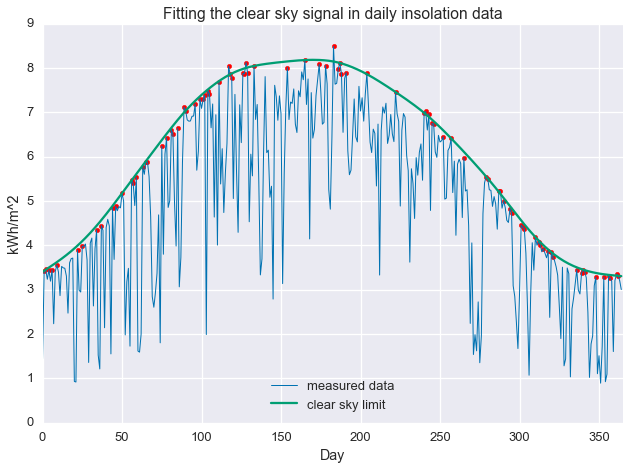

In [69]:
clear_days = np.divide(daily_insol, fit.value.A1) >= 0.97
plt.plot(daily_insol, linewidth=1, label='measured data')
plt.plot(fit.value.A1, label='clear sky limit')
plt.scatter(np.arange(len(daily_insol))[clear_days], daily_insol[clear_days], color='red')
plt.ylabel('kWh')
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.xlim(0, 365)
plt.title('Fitting the clear sky signal in daily insolation data')
plt.legend(loc=8)
plt.show()

This procedure has selected days that are at the "top" of the seasonal cutoff. As we can see below, these days are, in fact, quite clear.

In [ ]:
D = ghi.reshape(-1, 24)

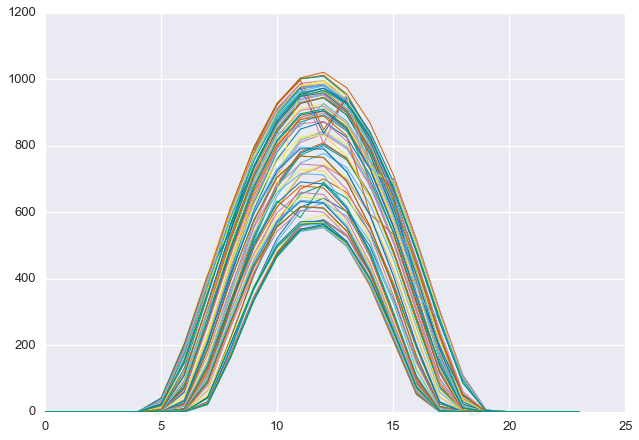

In [68]:
plt.plot(D[clear_days].T, linewidth=1)
plt.show()

Alternatively, we can select for the "least clear" days. Below we find the 50 least clear days

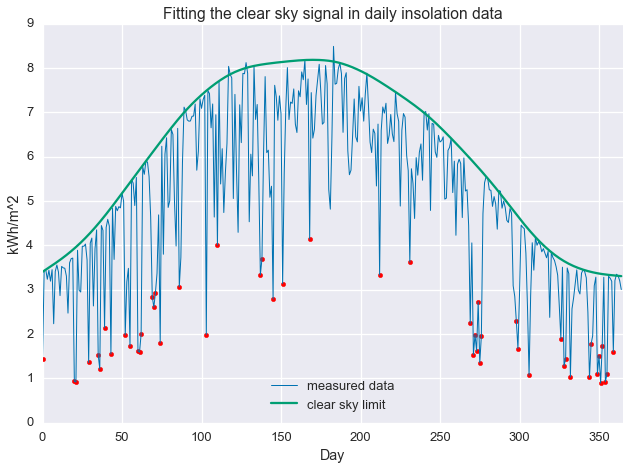

In [71]:
energy_rank = np.argsort(-np.divide(daily_insol, fit.value.A1))
cloudy_days = energy_rank[-50:]
plt.plot(daily_insol, linewidth=1, label='measured data')
plt.plot(fit.value.A1, label='clear sky limit')
plt.scatter(np.arange(len(daily_insol))[cloudy_days], daily_insol[cloudy_days], color='red')
plt.ylabel('kWh')
plt.ylabel('kWh/m^2')
plt.xlabel('Day')
plt.xlim(0, 365)
plt.title('Fitting the clear sky signal in daily insolation data')
plt.legend(loc=8)
plt.show()

Notice that some of the least-clear days in the summer still contain more energy than the most clear days in the winter. This is why total energy, by itself, is not a good proxy for daily clearness. Below, we see that the selected days are, in fact, quite cloudy.

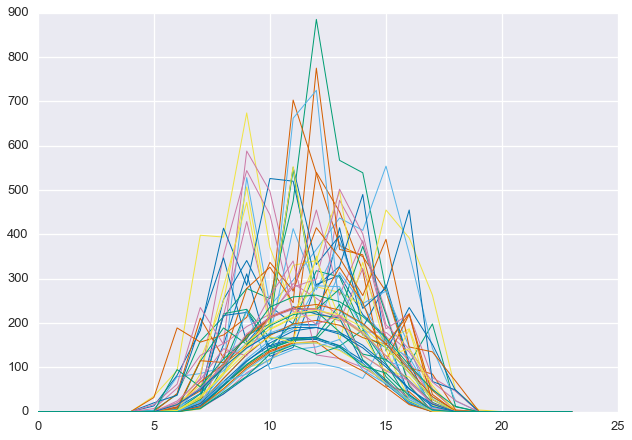

In [72]:
plt.plot(D[cloudy_days].T, linewidth=1)
plt.show()

The clear sky signal we found separates clear days from cloudy days in the data set. In other words, we can interpret the ratio $\kappa$ as a _daily clearness index_, which is roughly the amount of solar energy in one day divided by the maximum amount possible under full sun conditions.